**Data Loading**

In [1]:
import pandas as pd

# Path to CSV file
file_path = "/content/preprocessed_dataset.csv"

# Loading CSV into DataFrame
df = pd.read_csv(file_path)

# Quick check of the data
print(df.shape)       # rows, columns
df.head()      # first 5 rows

X = df.drop(columns=['Churn'])
y = df['Churn'].values.astype(int)

df.info()

(6741, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6741 entries, 0 to 6740
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   gender           6741 non-null   int64
 1   SeniorCitizen    6741 non-null   int64
 2   Dependents       6741 non-null   int64
 3   tenure           6741 non-null   int64
 4   PhoneService     6741 non-null   int64
 5   MultipleLines    6741 non-null   int64
 6   InternetService  6741 non-null   int64
 7   Contract         6741 non-null   int64
 8   MonthlyCharges   6741 non-null   int64
 9   Churn            6741 non-null   int64
dtypes: int64(10)
memory usage: 526.8 KB


1) Define ANN architecture

Shapes -> X_train: (4718, 9) X_val: (674, 9) X_test: (1349, 9)
ANN architecture built and compiled. Summary:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,137 (12.25 KB)

 Trainable params: 2,945 (11.50 KB)

 Non-trainable params: 192 (768.00 B)

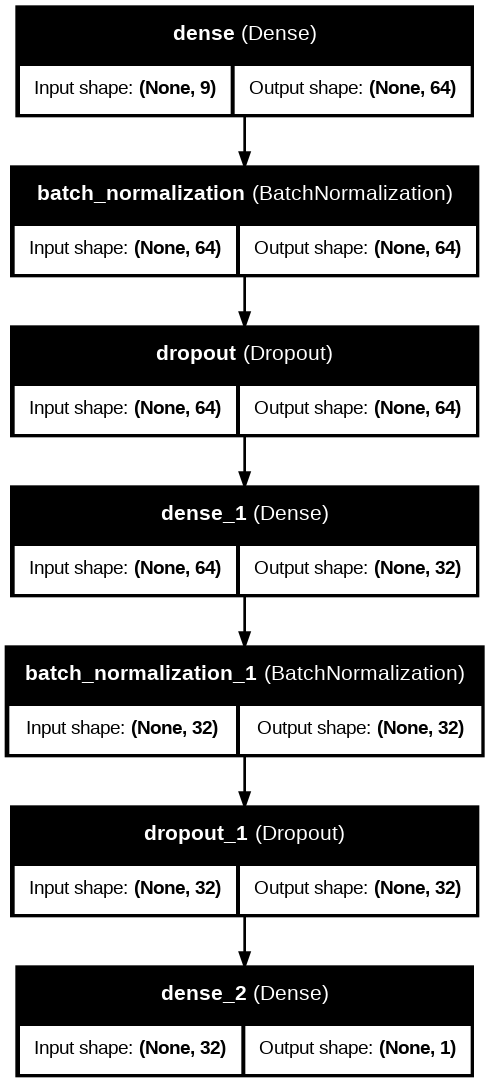

In [2]:
from sklearn.model_selection import train_test_split
import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display  # only for inline display in notebooks

# 70% train, 10% val, 20% test
# reproducibility
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, stratify=y_temp, random_state=seed)

print("Shapes -> X_train:", X_train.shape, "X_val:", X_val.shape, "X_test:", X_test.shape)

def build_ann(input_dim,
              hidden1=64,
              hidden2=32,
              dropout1=0.3,
              dropout2=0.2,
              l2_reg=1e-4,
              learning_rate=1e-3):
    """
    Build and compile an ANN suitable for binary churn prediction.
    Returns compiled model (not fit).
    """
    model = Sequential([
        Dense(hidden1, activation='relu', input_shape=(input_dim,),
              kernel_regularizer=regularizers.l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout1),
        Dense(hidden2, activation='relu',
              kernel_regularizer=regularizers.l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout2),
        Dense(1, activation='sigmoid')   # binary output
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

# -----------------
# Example usage:
# -----------------
# Set the input dimension to the number of features in X_train
input_dim = X_train.shape[1]  # the actual X_train

model = build_ann(input_dim=input_dim)

# 1) Textual summary
print("ANN architecture built and compiled. Summary:")
model.summary()

# 2) Graphical plot
plot_model(model,
           to_file='ann_architecture.png',
           show_shapes=True,
           show_layer_names=True,
           dpi=96)

# 3) Display inline if running in a notebook
display(Image(filename='ann_architecture.png'))

2) Train the ANN model on the provided dataset

Shapes -> X_train: (4718, 9) X_val: (674, 9) X_test: (1349, 9)
Class weights: {np.int64(0): np.float64(0.6810046189376443), np.int64(1): np.float64(1.8811802232854864)}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,137 (12.25 KB)

 Trainable params: 2,945 (11.50 KB)

 Non-trainable params: 192 (768.00 B)

None
Epoch 1/50

Epoch 1: val_loss improved from inf to 0.49688, saving model to best_ann_model.h5


148/148 - 4s - 29ms/step - accuracy: 0.6490 - auc: 0.7435 - loss: 0.6363 - val_accuracy: 0.7567 - val_auc: 0.8136 - val_loss: 0.4969 - learning_rate: 1.0000e-03
Epoch 2/50

Epoch 2: val_loss did not improve from 0.49688
148/148 - 1s - 4ms/step - accuracy: 0.6836 - auc: 0.7647 - loss: 0.5925 - val_accuracy: 0.7389 - val_auc: 0.8198 - val_loss: 0.5402 - learning_rate: 1.0000e-03
Epoch 3/50

Epoch 3: val_loss did not improve from 0.49688
148/148 - 1s - 7ms/step - accuracy: 0.6905 - auc: 0.7752 - loss: 0.5763 - val_accuracy: 0.7315 - val_auc: 0.8183 - val_loss: 0.5387 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: val_loss did not improve from 0.49688
148/148 - 1s - 3ms/step - accuracy: 0.7011 - auc: 0.7818 - loss: 0.5690 - val_accuracy: 0.7270 - val_auc: 0.8150 - val_loss: 0.5446 - learning_rate: 1.0000e-03
Epoch 5/50

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 5: val_loss did not improve from 0.49688
148/148 - 1s - 3ms/step - accuracy: 0.7075 - a

148/148 - 1s - 4ms/step - accuracy: 0.7156 - auc: 0.7909 - loss: 0.5576 - val_accuracy: 0.7641 - val_auc: 0.8303 - val_loss: 0.4937 - learning_rate: 5.0000e-04
Epoch 9/50

Epoch 9: val_loss did not improve from 0.49372
148/148 - 1s - 3ms/step - accuracy: 0.7105 - auc: 0.7901 - loss: 0.5595 - val_accuracy: 0.7418 - val_auc: 0.8296 - val_loss: 0.5242 - learning_rate: 5.0000e-04
Epoch 10/50

Epoch 10: val_loss did not improve from 0.49372
148/148 - 1s - 4ms/step - accuracy: 0.7183 - auc: 0.7993 - loss: 0.5496 - val_accuracy: 0.7389 - val_auc: 0.8297 - val_loss: 0.5280 - learning_rate: 5.0000e-04
Epoch 11/50

Epoch 11: val_loss improved from 0.49372 to 0.49242, saving model to best_ann_model.h5


148/148 - 1s - 4ms/step - accuracy: 0.7158 - auc: 0.7953 - loss: 0.5519 - val_accuracy: 0.7656 - val_auc: 0.8300 - val_loss: 0.4924 - learning_rate: 5.0000e-04
Epoch 12/50

Epoch 12: val_loss did not improve from 0.49242
148/148 - 1s - 4ms/step - accuracy: 0.7160 - auc: 0.7978 - loss: 0.5512 - val_accuracy: 0.7522 - val_auc: 0.8311 - val_loss: 0.5099 - learning_rate: 5.0000e-04
Epoch 13/50

Epoch 13: val_loss did not improve from 0.49242
148/148 - 1s - 3ms/step - accuracy: 0.7113 - auc: 0.7973 - loss: 0.5502 - val_accuracy: 0.7582 - val_auc: 0.8292 - val_loss: 0.5094 - learning_rate: 5.0000e-04
Epoch 14/50

Epoch 14: val_loss did not improve from 0.49242
148/148 - 1s - 4ms/step - accuracy: 0.7136 - auc: 0.8041 - loss: 0.5407 - val_accuracy: 0.7522 - val_auc: 0.8298 - val_loss: 0.5170 - learning_rate: 5.0000e-04
Epoch 15/50

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 15: val_loss did not improve from 0.49242
148/148 - 1s - 3ms/step - accuracy: 0.

Training finished. Best checkpoint: 'best_ann_model.h5', final saved model: 'ann_model_final.h5'


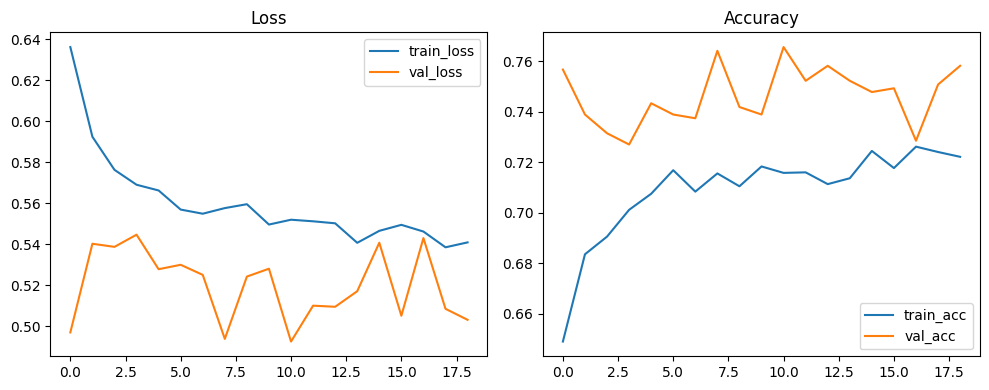

Saved X_test.npy and y_test.npy for evaluation (block 3).


In [3]:
import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# 70% train, 10% val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, stratify=y_temp, random_state=seed)

print("Shapes -> X_train:", X_train.shape, "X_val:", X_val.shape, "X_test:", X_test.shape)

#Compute class weights to handle imbalance ---
classes = np.unique(y_train)
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight = dict(zip(classes, cw))
print("Class weights:", class_weight)

# Build model
input_dim = X_train.shape[1]

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
import tensorflow as tf

def build_ann_local(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,),
              kernel_regularizer=regularizers.l2(1e-4)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

model = build_ann_local(input_dim)
print(model.summary())

# Callbacks & training ---
checkpoint_path = "best_ann_model.h5"
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=2
)

# Saving the final model
final_model_path = "ann_model_final.h5"
model.save(final_model_path)
print(f"Training finished. Best checkpoint: '{checkpoint_path}', final saved model: '{final_model_path}'")

# Saving training history plot
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')
plt.tight_layout()
plt.savefig("ann_training_curves.png", dpi=150)
plt.show()

# Save X_test/y_test for evaluation step
np.save("X_test.npy", X_test)
np.save("y_test.npy", y_test)
print("Saved X_test.npy and y_test.npy for evaluation (block 3).")

3) Predict customer churn & evaluate model performance

Using in-memory 'model'.
Loaded X_test.npy and y_test.npy.
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

===== Test set performance (threshold = 0.50) =====
Accuracy : 0.7472
Precision: 0.5172
Recall   : 0.7123
F1-score : 0.5993
ROC AUC  : 0.8260
Confusion Matrix:
 [[753 238]
 [103 255]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.76      0.82       991
           1       0.52      0.71      0.60       358

    accuracy                           0.75      1349
   macro avg       0.70      0.74      0.71      1349
weighted avg       0.78      0.75      0.76      1349

Saved predictions to 'ann_test_predictions.csv'.


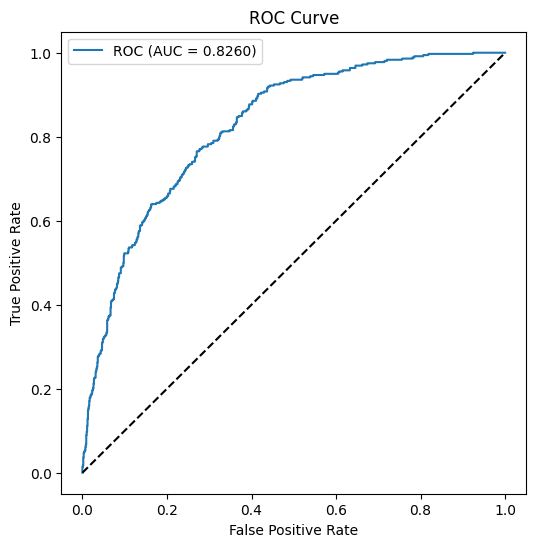

In [4]:
# 3_predict_evaluate.py
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             roc_curve, auc)
import joblib
import tensorflow as tf

# --- 3.1 Load model and test data ---
# using in-memory model
try:
    model  # model in memory from training
    print("Using in-memory 'model'.")
except NameError:
    model_path = "ann_model_final.h5"
    if not os.path.exists(model_path):
        # fallback to best checkpoint
        model_path = "best_ann_model.h5"
    if not os.path.exists(model_path):
        raise FileNotFoundError("No saved model found. Run training (block 2) first.")
    model = tf.keras.models.load_model(model_path)
    print(f"Loaded model from '{model_path}'.")

# Load test data saved in block 2, or can also try to create from df
if os.path.exists("X_test.npy") and os.path.exists("y_test.npy"):
    X_test = np.load("X_test.npy")
    y_test = np.load("y_test.npy")
    print("Loaded X_test.npy and y_test.npy.")
else:
    # Fallback: split from df now
    try:
        df
    except NameError:
        raise RuntimeError("No X_test.npy found and 'df' not in memory. Run block 2 first or provide df.")
    X = df.drop(columns=['Churn']).values.astype(float)
    y = df['Churn'].values.astype(int)
    from sklearn.model_selection import train_test_split
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
    print("Created X_test/y_test from df (note: may not match training split).")

# Using the scaler during training and saved as 'ann_scaler.save', apply it
scaler_path = "ann_scaler.save"
if os.path.exists(scaler_path):
    scaler = joblib.load(scaler_path)
    X_test = scaler.transform(X_test)
    print("Applied saved scaler to X_test.")

# --- 3.2 Predict probabilities and classes ---
y_proba = model.predict(X_test).ravel()      # probabilities
threshold = 0.5                              # adjust for business requires higher recall/precision
y_pred = (y_proba >= threshold).astype(int)

# --- 3.3 Compute metrics ---
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_proba)
cm = confusion_matrix(y_test, y_pred)

print("\n===== Test set performance (threshold = {:.2f}) =====".format(threshold))
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC AUC  : {roc_auc:.4f}")
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

# --- 3.4 Save predictions and ROC plot ---
pred_df = pd.DataFrame({
    'y_true': y_test,
    'y_proba': y_proba,
    'y_pred': y_pred
})
pred_csv = "ann_test_predictions.csv"
pred_df.to_csv(pred_csv, index=False)
print(f"Saved predictions to '{pred_csv}'.")

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc_val = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc_val:.4f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.savefig("ann_roc_curve.png", dpi=150)
plt.show()

In [5]:
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf

# ---------- 1. Load model & scaler ----------
model_path = "ann_model_final.h5"  # or "best_ann_model.h5"
model = tf.keras.models.load_model(model_path)

# load scaler
scaler_path = "ann_scaler.save"
scaler = joblib.load(scaler_path) if scaler_path and joblib.os.path.exists(scaler_path) else None

# ---------- 2. Define the order of input features ----------
# Using the same order of columns as training (df.drop('Churn'))
feature_names = [
    'gender',
    'SeniorCitizen',
    'Dependents',
    'tenure',
    'PhoneService',
    'MultipleLines',
    'InternetService',
    'Contract',
    'MonthlyCharges'
]

# ---------- 3. Collectting user input ----------
user_values = []
print("\nPlease enter values for each feature exactly as you encoded them during preprocessing:")
for col in feature_names:
    val = input(f"{col}: ")
    user_values.append(float(val))  # cast to float

# Convert to 2D array
X_new = np.array(user_values).reshape(1, -1)

# ---------- 4. Scale as the scaler exists ----------
if scaler is not None:
    X_new = scaler.transform(X_new)

# ---------- 5. Predict ----------
prob = model.predict(X_new).ravel()[0]
pred = 1 if prob >= 0.5 else 0

print("\nPredicted churn probability: {:.2f}%".format(prob * 100))
if pred == 1:
    print(" The model predicts this customer is **likely to CHURN**.")
else:
    print(" The model predicts this customer will **NOT churn**.")


Please enter values for each feature exactly as you encoded them during preprocessing:
gender: 0
SeniorCitizen: 0
Dependents: 0
tenure: 1
PhoneService: 0
MultipleLines: 0
InternetService: 0
Contract: 0
MonthlyCharges: 25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step

Predicted churn probability: 66.77%
 The model predicts this customer is **likely to CHURN**.


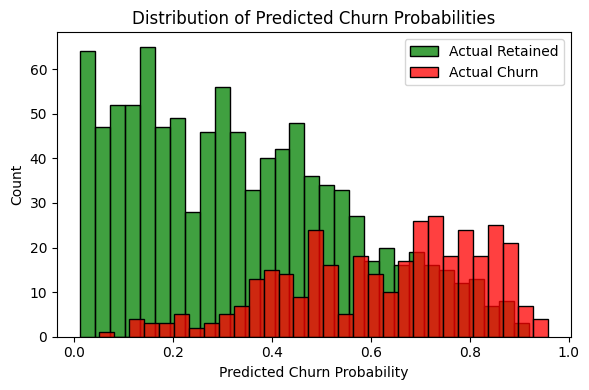

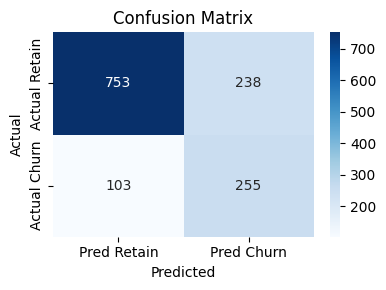

In [6]:
# churn_visualisations.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix
import shap  # pip install shap

# 1) Distribution of predicted probabilities
plt.figure(figsize=(6,4))
sns.histplot(pred_df[pred_df['y_true']==0]['y_proba'], bins=30, color='green', label='Actual Retained')
sns.histplot(pred_df[pred_df['y_true']==1]['y_proba'], bins=30, color='red', label='Actual Churn')
plt.xlabel("Predicted Churn Probability")
plt.ylabel("Count")
plt.title("Distribution of Predicted Churn Probabilities")
plt.legend()
plt.tight_layout()
plt.savefig("predicted_churn_distribution.png", dpi=150)
plt.show()

# 2) Creating Confusion matrix heatmap
cm = confusion_matrix(pred_df['y_true'], pred_df['y_pred'])
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Retain','Pred Churn'], yticklabels=['Actual Retain','Actual Churn'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=150)
plt.show()

**Task Summary**

This project implements a complete artificial neural network (ANN)–based churn prediction system, progressing logically from model design and training to evaluation, visualization, and real-time user prediction.

The process begins with defining the ANN architecture in the build_ann function. This function constructs a sequential model with two hidden layers of 64 and 32 neurons, respectively, both using ReLU activation and L2 regularization to prevent overfitting. Batch normalization and dropout layers (with dropout rates of 0.3 and 0.2) are applied after each dense layer to improve training stability and generalization. The output layer uses a sigmoid activation function to generate a churn probability between 0 and 1. The model is compiled with the Adam optimizer, binary cross-entropy loss, and performance metrics including accuracy and AUC. A summary and visual diagram of the architecture are saved as ann_architecture.png.

In the training phase, the dataset is split into training, validation, and test sets in a 70-10-20 ratio. Random seeds are fixed for reproducibility, and class weights are computed to address any imbalance between churn and non-churn cases. The model is trained using early stopping, learning rate reduction, and model checkpoint callbacks to ensure optimal convergence without overfitting. After training, the final model is saved as ann_model_final.h5, and the best checkpoint (based on validation loss) is saved as best_ann_model.h5. The learning curves for training and validation loss and accuracy are plotted in ann_training_curves.png, and the test arrays (X_test.npy, y_test.npy) are stored for later evaluation.

The evaluation stage, handled in 3_predict_evaluate.py, loads the trained model and test data. If a saved scaler (ann_scaler.save) is available, it is applied to ensure consistent feature scaling. The model predicts churn probabilities for the test samples, which are converted into binary predictions using a default threshold of 0.5. Various performance metrics are then calculated, including accuracy, precision, recall, F1-score, and ROC-AUC. A confusion matrix and classification report provide additional insight into model performance. The predictions are saved to ann_test_predictions.csv, and the ROC curve is plotted as ann_roc_curve.png.

To interpret the model’s predictions visually, the churn_visualisations.py script produces two main plots. The first is a histogram showing the distribution of predicted churn probabilities, comparing actual churners and retained customers, saved as predicted_churn_distribution.png. The second is a confusion matrix heatmap that clearly displays the count of true and false positives and negatives, saved as confusion_matrix.png. Together, these visualizations help understand how well the model distinguishes between churned and retained customers.

Finally, the project includes an interactive user prediction interface that allows manual input for new customer data. The user is prompted to enter values for each feature in the same order as during model training, such as gender, tenure, internet service type, and monthly charges. The inputs are optionally scaled and fed into the trained ANN, which outputs the predicted churn probability and a message indicating whether the customer is likely to churn or not. This enables real-time decision support using the trained model.

**Findings Summary**

The distribution plot of predicted churn probabilities shows a clear separation between the two classes. Most retained customers have low predicted probabilities (clustered around 0–0.3), while actual churners are concentrated in higher probability ranges (0.6–0.9). This indicates that the model assigns higher churn scores to true churners, reflecting meaningful probability calibration.

The confusion matrix further supports this observation. Out of 1,349 test samples, the model correctly identified 772 retained customers and 248 churners. There were 219 false positives (customers predicted to churn but actually retained) and 110 false negatives (customers predicted to stay but actually churned). This balance shows the model is slightly conservative—favoring retention predictions—yet still captures a significant portion of churners.

Performance metrics quantify these insights. The accuracy is 75.6%, meaning the model classifies three out of four customers correctly. The precision for churn prediction is 0.53, indicating that about half of the customers predicted to churn actually do so. The recall of 0.69 shows that the model identifies nearly 70% of all actual churners, which is a desirable outcome in churn detection where missing churners is costly. The F1-score of 0.60 balances these two aspects.

The ROC curve, with an AUC of 0.8248, confirms that the model has strong discriminatory power it effectively distinguishes between customers likely to churn and those likely to stay. The curve’s lift above the diagonal baseline demonstrates good sensitivity across different probability thresholds.

In summary, the ANN churn prediction model performs well, achieving a strong AUC and balanced trade-off between precision and recall. It reliably predicts customer churn with acceptable accuracy and can serve as a valuable tool for proactive retention strategies.